In [179]:
import tensorflow as tf
from keras.layers import Rescaling,Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt

import numpy as np
import os
import random
from PIL import Image

In [180]:
print(tf.__version__)

2.13.0


In [181]:
ds_dir = "/Users/abramtan/Desktop/rice-classification/Rice_Image_Dataset"

In [182]:
labels = np.array(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'])
X = []
y = []
samples = 15000
pixels = 50

for label in labels:
    folder = ds_dir + '/' + label + '/'
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    for i in range(samples):
        img = Image.open(folder + "/" + files[i])
        img.thumbnail((pixels, pixels)) # resize to 50 x 50
        img_array = np.asarray(img)
        X.append(img_array)
        y.append(label)

X = np.asarray(X)
y_string = np.array(y)

print(X.shape)
print(y_string.shape)

(75000, 50, 50, 3)
(75000,)


In [183]:
# String to integer encoding of labels for use with CNN
labels, y = np.unique(y_string, return_inverse=True)
print(labels)
print(y)
print(y_string)

['Arborio' 'Basmati' 'Ipsala' 'Jasmine' 'Karacadag']
[0 0 0 ... 4 4 4]
['Arborio' 'Arborio' 'Arborio' ... 'Karacadag' 'Karacadag' 'Karacadag']


In [184]:
# Split dataset into 0.7 for train, 0.15 for val, 0.15 for test
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(52500, 50, 50, 3)
(52500,)
(11250, 50, 50, 3)
(11250,)
(11250, 50, 50, 3)
(11250,)


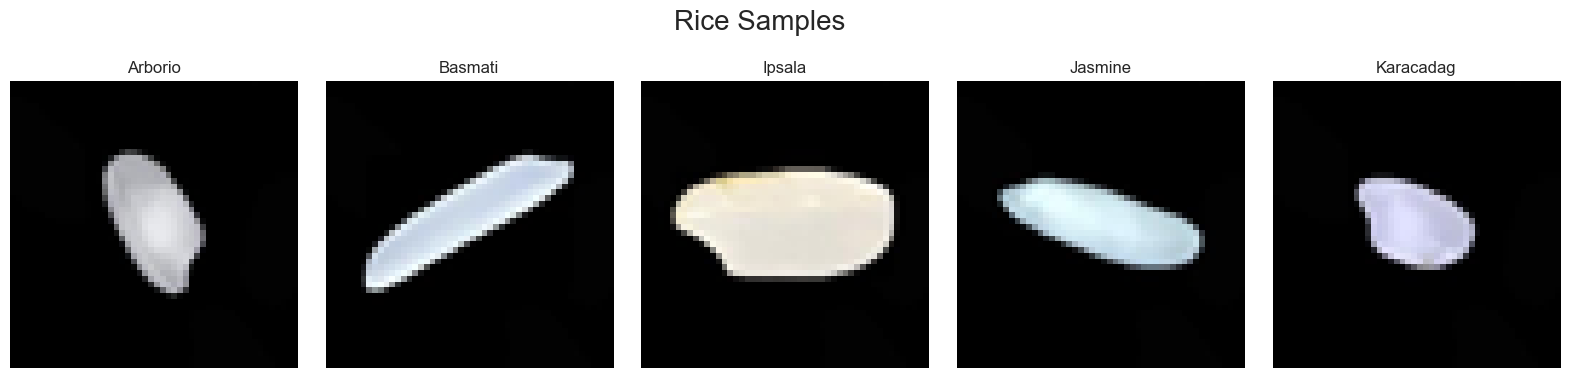

In [185]:
# Show rice
def show_rice(X, y_string, cols=5, title=None):
    fig, axs = plt.subplots(1, cols, figsize=(20,5))
    plt.axis('off')
    for i in range(len(labels)):
        rice = labels[i]
        idx = np.argwhere(y_string == rice)[0]
        im = X[idx].reshape(50,50,3)
        axs[i].set_title(f'{rice}')
        axs[i].imshow(im)
        axs[i].axis('off')
    # change the spacing between the subplots
    plt.subplots_adjust(wspace=0.1, hspace=-0.3)
    if title is not None:
        fig.suptitle(title,fontsize=20)
        fig.subplots_adjust(top=0.99)
    
show_rice(X, y_string, title='Rice Samples')

In [186]:
# Number of labels
num_classes = 5

In [187]:
# Function to show a sample of 6 images that have been predicted by the model
def show_test_images(model,images, true_labels, classes):

    plt.figure(figsize=(7,7))

    for i in range(6):
        ax=plt.subplot(2,3,i+1)
        rand_index=random.choice(range(len(images)))

        #Make prediction
        target_image=images[rand_index]
        pred_probs=model.predict(tf.expand_dims(target_image,axis=0))
        pred_label=classes[pred_probs.argmax()]
        true_label= classes[true_labels[rand_index]]
        plt.imshow(target_image,cmap=plt.cm.binary)
        plt.xlabel("Pred:{} {:2.0f}% \n(True:{})".format(pred_label,
                                             100*tf.reduce_max(pred_probs),
                                             true_label), fontsize=10)

In [212]:
# Convolution + pooling layer
cnn0 = Sequential([
  Rescaling(1./255),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation='softmax')
])

In [193]:
cnn0.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [194]:
trained_cnn0 = cnn0.fit(
  X_train, y_train,
  validation_data=(X_val,y_val),
  epochs=10
)

Epoch 1/10
1641/1641 [==============================] - 23s 14ms/step - loss: 0.0962 - accuracy: 0.9675 - val_loss: 0.0484 - val_accuracy: 0.9844
Epoch 2/10
1641/1641 [==============================] - 21s 13ms/step - loss: 0.0428 - accuracy: 0.9860 - val_loss: 0.0667 - val_accuracy: 0.9756
Epoch 3/10
1641/1641 [==============================] - 21s 13ms/step - loss: 0.0362 - accuracy: 0.9876 - val_loss: 0.0242 - val_accuracy: 0.9910
Epoch 4/10
1641/1641 [==============================] - 22s 13ms/step - loss: 0.0309 - accuracy: 0.9897 - val_loss: 0.0314 - val_accuracy: 0.9887
Epoch 5/10
1641/1641 [==============================] - 20s 12ms/step - loss: 0.0272 - accuracy: 0.9907 - val_loss: 0.0324 - val_accuracy: 0.9897
Epoch 6/10
1641/1641 [==============================] - 20s 12ms/step - loss: 0.0249 - accuracy: 0.9912 - val_loss: 0.0221 - val_accuracy: 0.9937
Epoch 7/10
1641/1641 [==============================] - 20s 12ms/step - loss: 0.0211 - accuracy: 0.9930 - val_loss: 0.0226 -

352/352 - 1s - loss: 0.0449 - accuracy: 0.9852 - 1s/epoch - 4ms/step
0.9852444529533386


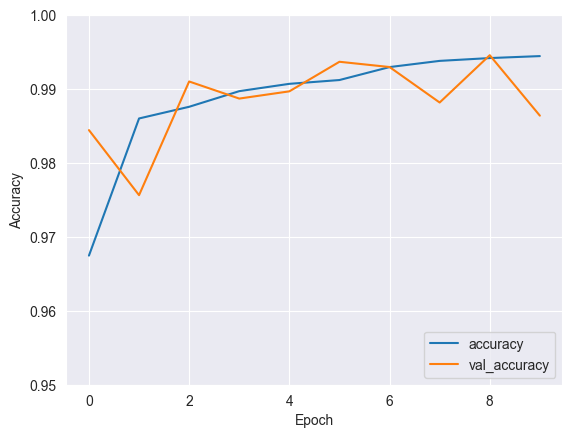

In [195]:
plt.plot(trained_cnn0.history['accuracy'], label='accuracy')
plt.plot(trained_cnn0.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.95, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn0.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

1/1 [==============================] - 0s 9ms/step


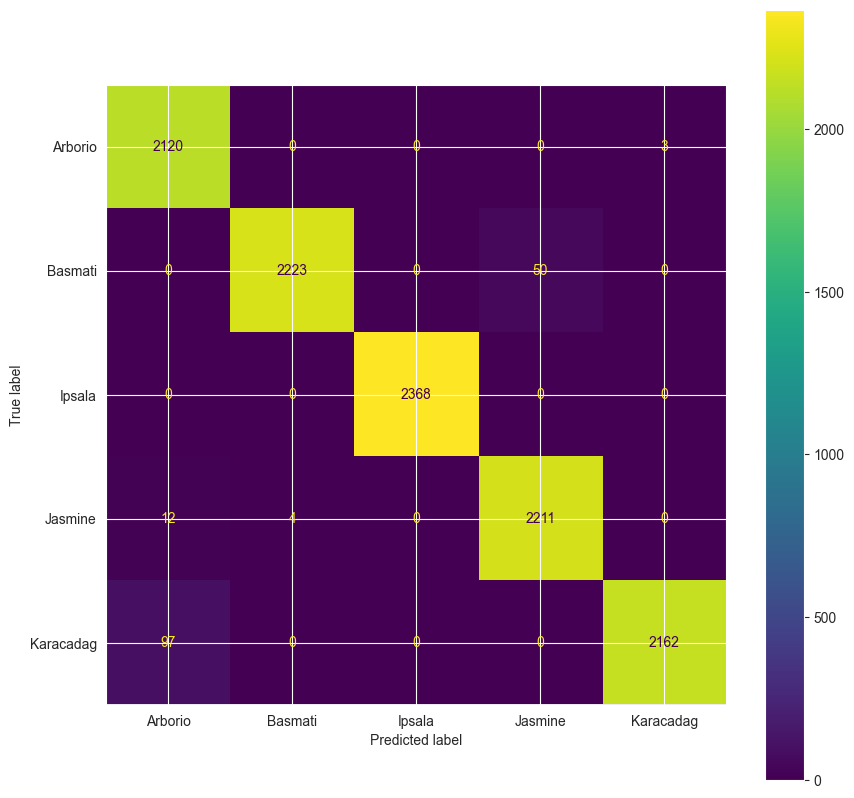

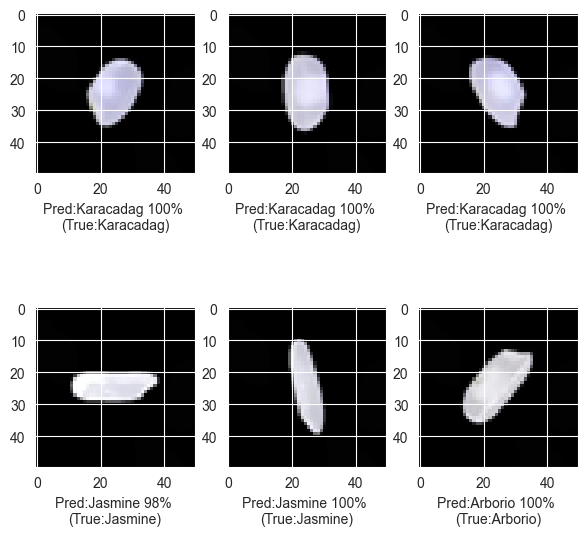

In [196]:
#Confusion matrix
y_probs = cnn0.predict(X_test)
y_preds = y_probs.argmax(axis=1)
cm=confusion_matrix(y_preds,y_test)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

#Run to make random predictions
show_test_images(cnn0,X_test,y_test,labels)

In [197]:
#  LeNet-5 architecture
cnn1 = Sequential([
    Rescaling(1./255),
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [198]:
cnn1.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [199]:
trained_cnn1 = cnn1.fit(
  X_train, y_train,
  validation_data=(X_val,y_val),
  epochs=10
)

Epoch 1/10
1641/1641 [==============================] - 16s 10ms/step - loss: 0.1371 - accuracy: 0.9508 - val_loss: 0.0869 - val_accuracy: 0.9703
Epoch 2/10
1641/1641 [==============================] - 16s 9ms/step - loss: 0.0789 - accuracy: 0.9725 - val_loss: 0.0479 - val_accuracy: 0.9846
Epoch 3/10
1641/1641 [==============================] - 16s 10ms/step - loss: 0.0498 - accuracy: 0.9833 - val_loss: 0.0466 - val_accuracy: 0.9838
Epoch 4/10
1641/1641 [==============================] - 15s 9ms/step - loss: 0.0368 - accuracy: 0.9870 - val_loss: 0.0356 - val_accuracy: 0.9878
Epoch 5/10
1641/1641 [==============================] - 15s 9ms/step - loss: 0.0303 - accuracy: 0.9898 - val_loss: 0.0179 - val_accuracy: 0.9941
Epoch 6/10
1641/1641 [==============================] - 15s 9ms/step - loss: 0.0230 - accuracy: 0.9922 - val_loss: 0.0200 - val_accuracy: 0.9940
Epoch 7/10
1641/1641 [==============================] - 15s 9ms/step - loss: 0.0194 - accuracy: 0.9936 - val_loss: 0.0161 - val_

352/352 - 1s - loss: 0.0155 - accuracy: 0.9943 - 1s/epoch - 3ms/step
0.9943110942840576


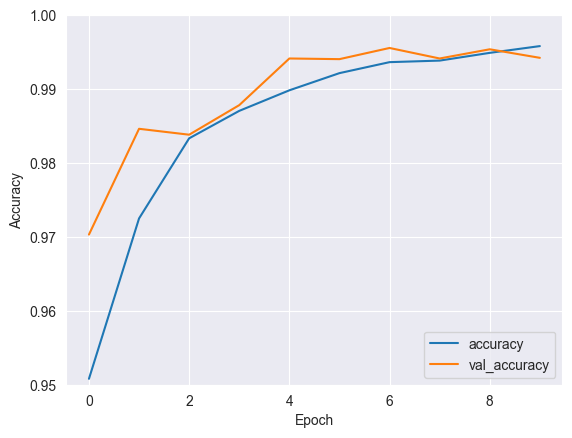

In [200]:
plt.plot(trained_cnn1.history['accuracy'], label='accuracy')
plt.plot(trained_cnn1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.95, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn1.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

1/1 [==============================] - 0s 9ms/step


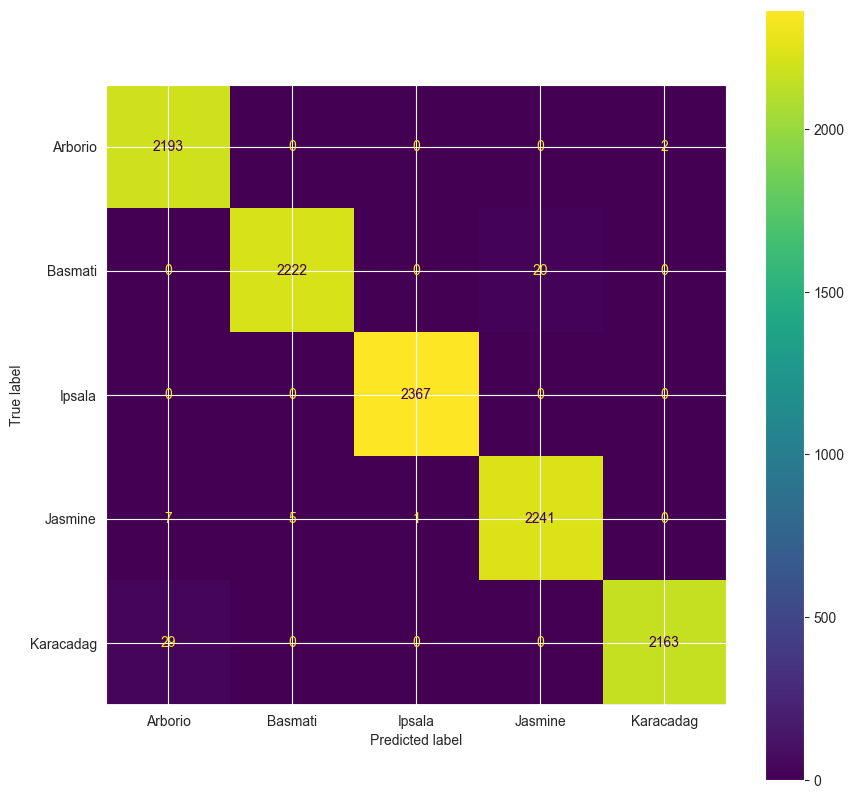

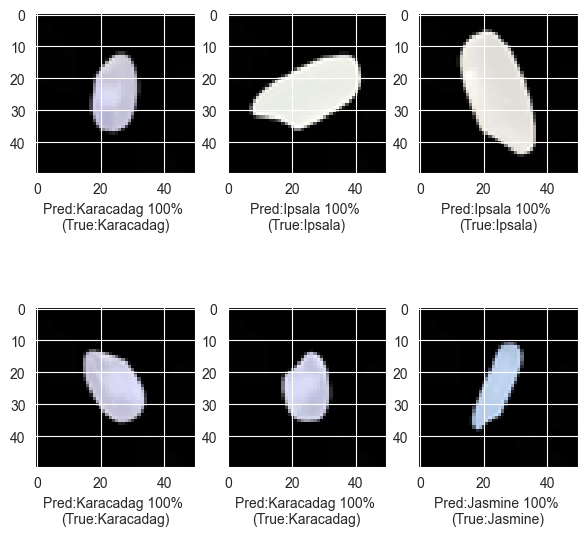

In [201]:
#Confusion matrix
y_probs = cnn1.predict(X_test)
y_preds = y_probs.argmax(axis=1)
cm=confusion_matrix(y_preds,y_test)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

#Run to make random predictions
show_test_images(cnn1,X_test,y_test,labels)

In [202]:
# Conv-Pool-Conv-Pool, doubling the number of filters every stage

cnn2 = Sequential([
    Rescaling(1./255),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [203]:
cnn2.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [204]:
trained_cnn2 = cnn2.fit(
  X_train, y_train,
  validation_data=(X_val,y_val),
  epochs=10
)

Epoch 1/10
1641/1641 [==============================] - 38s 23ms/step - loss: 0.1399 - accuracy: 0.9504 - val_loss: 0.0745 - val_accuracy: 0.9764
Epoch 2/10
1641/1641 [==============================] - 38s 23ms/step - loss: 0.0669 - accuracy: 0.9781 - val_loss: 0.0475 - val_accuracy: 0.9836
Epoch 3/10
1641/1641 [==============================] - 37s 23ms/step - loss: 0.0468 - accuracy: 0.9843 - val_loss: 0.0324 - val_accuracy: 0.9899
Epoch 4/10
1641/1641 [==============================] - 38s 23ms/step - loss: 0.0350 - accuracy: 0.9883 - val_loss: 0.0493 - val_accuracy: 0.9842
Epoch 5/10
1641/1641 [==============================] - 38s 23ms/step - loss: 0.0261 - accuracy: 0.9919 - val_loss: 0.0704 - val_accuracy: 0.9762
Epoch 6/10
1641/1641 [==============================] - 38s 23ms/step - loss: 0.0219 - accuracy: 0.9928 - val_loss: 0.0362 - val_accuracy: 0.9873
Epoch 7/10
1641/1641 [==============================] - 38s 23ms/step - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.0153 -

352/352 - 3s - loss: 0.0158 - accuracy: 0.9959 - 3s/epoch - 8ms/step
0.9959111213684082


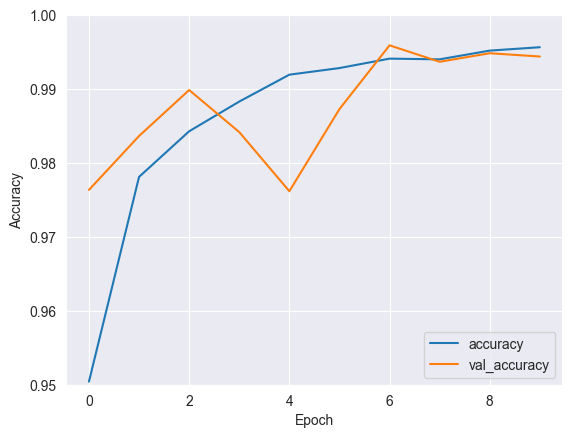

In [205]:
plt.plot(trained_cnn2.history['accuracy'], label='accuracy')
plt.plot(trained_cnn2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.95, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn2.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

1/1 [==============================] - 0s 9ms/step


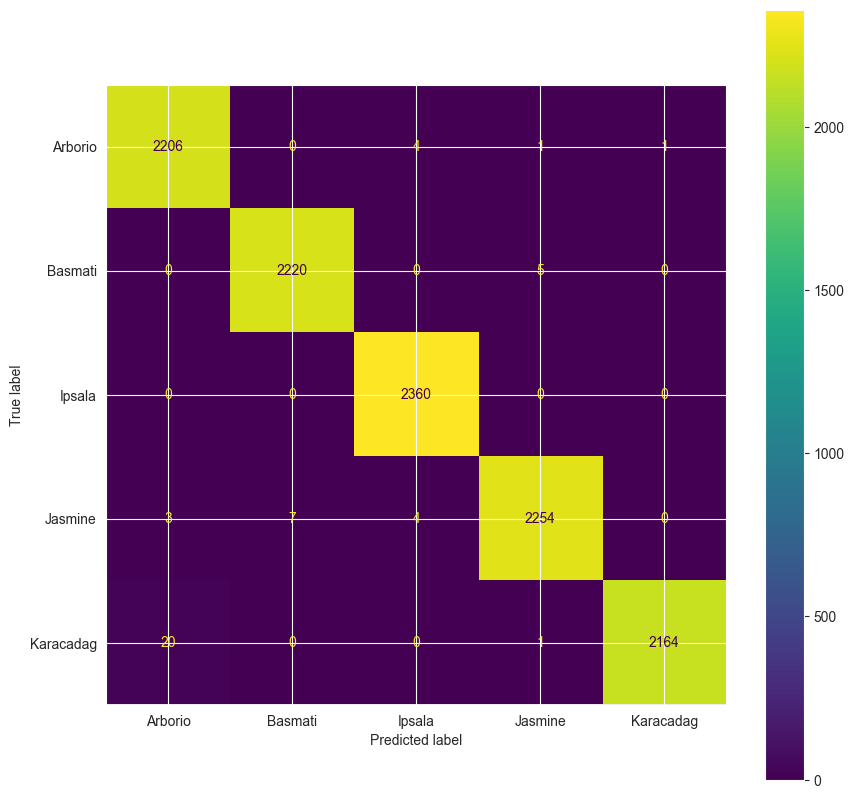

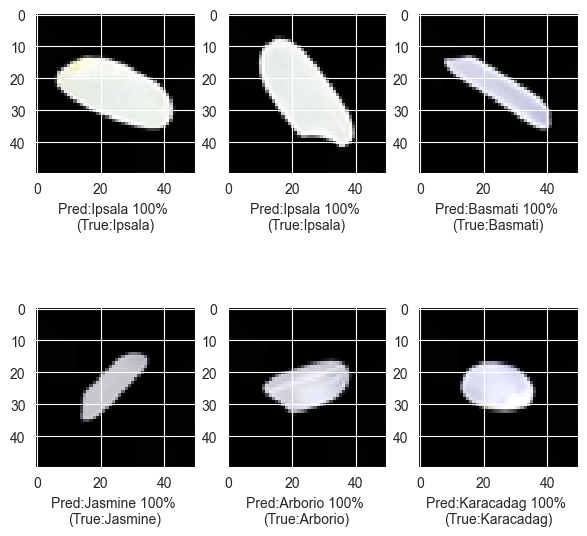

In [206]:
#Confusion matrix
y_probs = cnn2.predict(X_test)
y_preds = y_probs.argmax(axis=1)
cm=confusion_matrix(y_preds,y_test)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

#Run to make random predictions
show_test_images(cnn2,X_test,y_test,labels)

In [207]:
# vgg like model with the trend Conv-Conv-Pool-Conv-Conv-Pool

cnn3 = Sequential([
    Rescaling(1./255),
    Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same'),
    Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [208]:
cnn3.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [209]:
trained_cnn3 = cnn3.fit(
  X_train, y_train,
  validation_data=(X_val,y_val),
  epochs=10
)

Epoch 1/10
1641/1641 [==============================] - 46s 28ms/step - loss: 0.1300 - accuracy: 0.9546 - val_loss: 0.0948 - val_accuracy: 0.9670
Epoch 2/10
1641/1641 [==============================] - 46s 28ms/step - loss: 0.0686 - accuracy: 0.9773 - val_loss: 0.0566 - val_accuracy: 0.9820
Epoch 3/10
1641/1641 [==============================] - 46s 28ms/step - loss: 0.0459 - accuracy: 0.9848 - val_loss: 0.0391 - val_accuracy: 0.9873
Epoch 4/10
1641/1641 [==============================] - 47s 28ms/step - loss: 0.0386 - accuracy: 0.9871 - val_loss: 0.0313 - val_accuracy: 0.9899
Epoch 5/10
1641/1641 [==============================] - 46s 28ms/step - loss: 0.0341 - accuracy: 0.9879 - val_loss: 0.0292 - val_accuracy: 0.9910
Epoch 6/10
1641/1641 [==============================] - 47s 28ms/step - loss: 0.0266 - accuracy: 0.9917 - val_loss: 0.0217 - val_accuracy: 0.9938
Epoch 7/10
1641/1641 [==============================] - 47s 29ms/step - loss: 0.0218 - accuracy: 0.9927 - val_loss: 0.0211 -

352/352 - 3s - loss: 0.0146 - accuracy: 0.9952 - 3s/epoch - 8ms/step
0.995199978351593


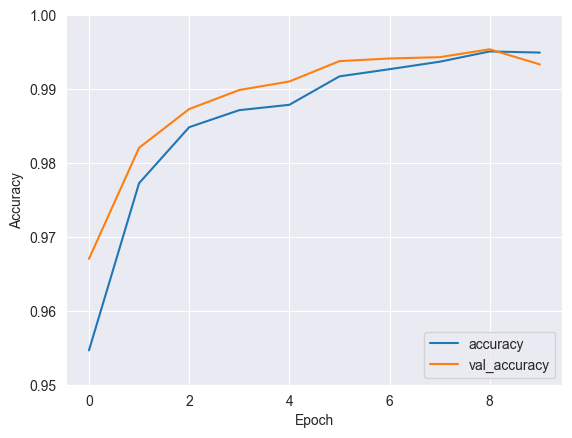

In [210]:
plt.plot(trained_cnn3.history['accuracy'], label='accuracy')
plt.plot(trained_cnn3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.95, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn3.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

1/1 [==============================] - 0s 10ms/step


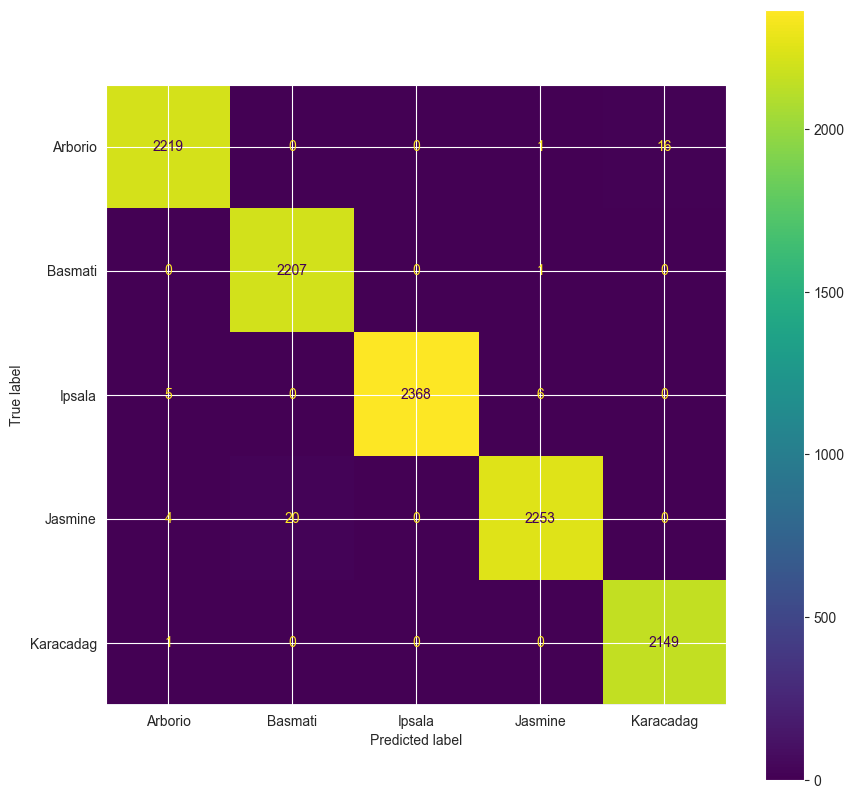

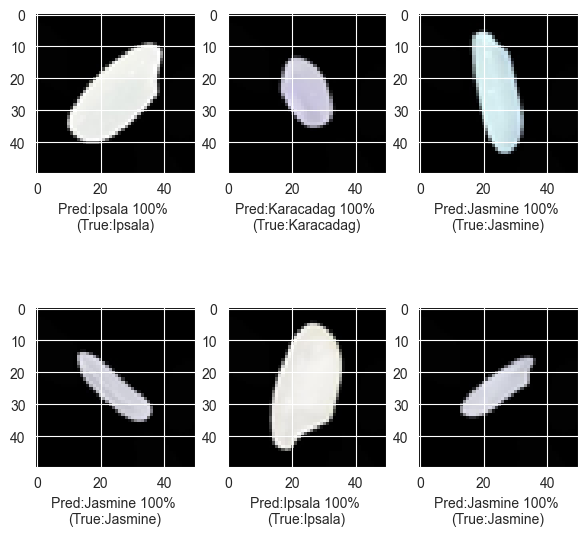

In [211]:
#Confusion matrix
y_probs = cnn3.predict(X_test)
y_preds = y_probs.argmax(axis=1)
cm=confusion_matrix(y_preds,y_test)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

#Run to make random predictions
show_test_images(cnn3,X_test,y_test,labels)